# Get a LSST Simulated Cadence for Arbitrary Sky Position
___


___

In [1]:
"""

"""
%matplotlib inline

from __future__ import print_function

try:
    from importlib import reload
except:
    pass


from matplotlib import pyplot as plt

import os
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from astropy import units as u
from astropy.coordinates import SkyCoord

import lsst_tools.utils as utils 

Connect to .db file that contains the opsim output, read into a dataframe, `opsimdf`

In [2]:
# %%timeit ## 1 loop, best of 3: 1min 31s per loop 
# opsimdbpath = os.environ.get('OPSIMDBPATH')
# print(opsimdbpath)
opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/astro_lsst_01_1068_sqlite.db"

conn = create_engine('sqlite:///'+opsimdbpath, echo = False)
opsimdf = pd.read_sql_table('Summary', con=conn)

In [3]:
#%%timeit ## The slowest run took 39.04 times longer than the fastest. This could mean that an intermediate result is being cached.
#         ## 1000 loops, best of 3: 246 µs per loop
n = 1
pos_df = utils.generate_coordinates(n)

Add extinction to the dataframe

In [4]:
#%%timeit ## 1 loop, best of 3: 88.6 ms per loop
df = utils.find_MW_extinction(pos_df) 

Check the positions are sensible

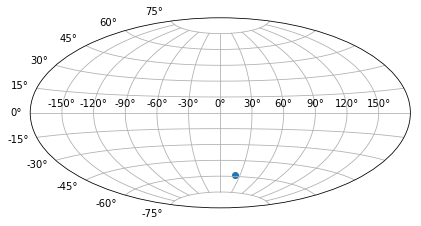

In [5]:
#%%timeit ## 1 loop, best of 3: 235 ms per loop
utils.plot_position_points(df)

Connecting to `.db` takes ages (~1min), and is a pain if you mess up, so create a 'working' instance to fiddle with

In [6]:
working_df = opsimdf

## Identifying Fields
___
We want to find out which field(s) the position is in. Create table that tells us the field centres, and find the edges.

In [7]:
# working_df = utils.get_field_corners(working_df.drop_duplicates("fieldID"))[['fieldRA', 'fieldDec']]
working_df = utils.get_field_corners(pd.DataFrame(working_df.drop_duplicates("fieldID"))[['fieldID', 'fieldRA', 'fieldDec']])

In [8]:
working_df

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower
0,505,1.720374,-0.936476,1.750917,1.689831,-0.967019,-0.905933
1,567,1.648235,-0.903353,1.678778,1.617692,-0.933896,-0.872810
2,561,1.563788,-0.915583,1.594331,1.533245,-0.946126,-0.885040
3,539,1.477422,-0.924531,1.507965,1.446879,-0.955074,-0.893988
4,531,1.389669,-0.930365,1.420212,1.359126,-0.960908,-0.899822
5,517,1.301075,-0.933239,1.331618,1.270532,-0.963782,-0.902696
6,519,1.212198,-0.933238,1.242741,1.181655,-0.963781,-0.902695
7,523,1.123604,-0.930366,1.154147,1.093061,-0.960909,-0.899823
8,541,1.035849,-0.924530,1.066392,1.005306,-0.955073,-0.893987
9,698,0.988892,-0.827713,1.019435,0.958349,-0.858256,-0.797170


In [9]:
field_df = working_df[(working_df["RA_upper"] >= df["theta"][0] + np.pi) &
                (working_df["RA_lower"] <= df["theta"][0] + np.pi) &
                (working_df["Dec_lower"] >= df["phi"][0])  &
                (working_df["Dec_upper"] <= df["phi"][0])]

NameError: name 'field_df' is not defined

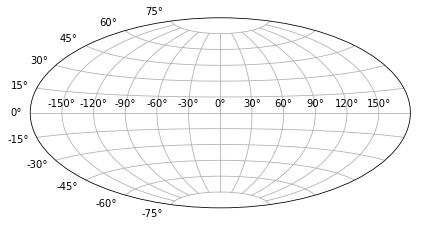

In [13]:
utils.plot_field(working_df)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/berto/.local/lib/python3.6/site-packages/lsst_tools-0.1-py3.6.egg'

In [15]:
df = opsimdf

In [19]:
## Work out how often each field is visited
df["fieldID"].value_counts()

1427    23271
744     22166
2412    20329
290     18202
2786    16852
380      1034
660      1034
462      1034
523      1034
519      1034
555      1033
392      1033
539      1033
563      1033
580      1033
903      1033
480      1033
607      1033
621      1033
388      1033
1021     1033
672      1033
698      1033
666      1032
408      1032
597      1032
766      1032
1110     1032
872      1032
486      1032
        ...  
187       180
3638      180
1322      180
186       180
528       180
200       180
1109      180
184       180
183       180
2231      180
182       180
181       180
190       180
2883      180
337       180
191       180
192       180
2241      180
193       180
194       180
389       180
1314      180
195       180
196       180
336       180
197       180
198       180
1738      180
199       180
1632      180
Name: fieldID, dtype: int64

In [ ]:
z